In [1]:
import h5py
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import layers, optimizers, activations, initializers,regularizers, constraints
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv1D,Convolution2D, MaxPooling1D, AlphaDropout, Layer, LSTM, Layer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
#from tensorflow_addons.layers import MultiHeadAttention
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn, json
import scipy.io as io
from sklearn.utils import shuffle
from typing import Any, Dict
import logging, sys
logging.disable(sys.maxsize)
path = '/home/usuario_gmr/'
sys.path.insert(0, path + "AMC/includes")
from clr_callback import *
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

2023-03-31 12:18:50.541027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
classes = ['LFM', 'LFM_triang', 'LFM_esc', '2FSK', '4FSK', '8FSK', 'Costas','2PSK', '4PSK', '8PSK', 'Barker', 'Frank', 'NM']
dataset_path = path + 'Hierarchical_data/'

In [3]:
with h5py.File(dataset_path +'X_test.mat', 'r') as f:
    X_test = np.array(f['X_test'], dtype='float32').T
Y_test = io.loadmat(dataset_path + 'Y_test.mat')
Y_test = Y_test['Y_test']
lbl_test = io.loadmat(dataset_path + 'lbl_test.mat')['lbl_test']

print("Y test shape: ", Y_test.shape)

Y test shape:  (62400, 13)


In [4]:
np.random.seed(2022)

In [5]:
X_test, Y_test, lbl_test = sklearn.utils.shuffle(X_test[:], Y_test[:],lbl_test[:], random_state=2022)

In [6]:
model = keras.models.load_model("/home/usuario_gmr/Results_hierarchical/300_epochs/best_model.h5")

2023-03-31 12:19:02.330153: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-31 12:19:02.330727: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-31 12:19:02.374198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 12:19:02.374294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-03-31 12:19:02.374308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-31 12:19:02.375336: I tensorflow/stream_executor/platform/de

In [7]:
def getConfusionMatrixPlot(true_labels, predicted_labels,title):
    plt.rcParams.update({'font.size': 18})
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)

    # create figure
    width = 18
    height = width / 1.618
    fig = plt.figure(figsize=(width, height))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    res = ax.imshow(cm, cmap=plt.cm.binary,
                    interpolation='nearest', vmin=0, vmax=1)

    # add color bar
    plt.colorbar(res)

    # annotate confusion entries
    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))

    # add genres as ticks
    alphabet = classes
    plt.xticks(range(width), alphabet[:width], rotation=30)
    plt.yticks(range(height), alphabet[:height])
    plt.title(title)
    return plt


def getFontColor(value):
    if np.isnan(value):
        return "black"
    elif value < 0.2:
        return "black"
    else:
        return "white"

In [8]:
output_path = "/home/usuario_gmr/Results_hierarchical/300_epochs"

In [9]:
signal_class = {classes[0]: np.zeros(16), classes[1]: np.zeros(16),classes[2]:np.zeros(16), classes[3] : np.zeros(16),
                classes[4]: np.zeros(16), classes[5]:np.zeros(16), classes[6]:np.zeros(16), classes[7]:np.zeros(16),
                classes[8]:np.zeros(16),classes[9]:np.zeros(16),classes[10]:np.zeros(16),classes[11]:np.zeros(16),
                classes[12]:np.zeros(16)}
snrs = [-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20]

In [ ]:

acc={}
for j,snr in enumerate(snrs):
    test_SNRs = list(map(lambda x: lbl_test[x][1], range(0,X_test.shape[0])))
    test_X_i = X_test[[i for i,x in enumerate(test_SNRs) if x==snr]]
    test_Y_i = Y_test[[i for i,x in enumerate(test_SNRs) if x==snr]]
    # estimate classes
    test_Y_i_hat = np.array(model.predict(test_X_i))
    cm = confusion_matrix(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,1))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)
    for i in range(len(classes)):
        signal_class[classes[i]][j]= cm[i][i]
    width = 18
    height = width / 1.618
    plt.figure(figsize=(width, height))
    plt = getConfusionMatrixPlot(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,1),title="Confusion Matrix (SNR=%d)"%(snr))
    plt.gcf().subplots_adjust(bottom=0.15)
    #plt.savefig(output_path + '/graphs/confmat_'+str(snr)+'.png')
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    cor = np.sum(np.diag(conf))
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
    #with open(output_path + '/acc.json', 'w') as f:
      #  json.dump(acc, f)


2023-03-31 12:19:15.110353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-31 12:19:15.110976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2023-03-31 12:19:15.576924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-31 12:19:15.802960: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [20]:
data= open(output_path + '/history_rnn.json')
fitting = json.load(data)

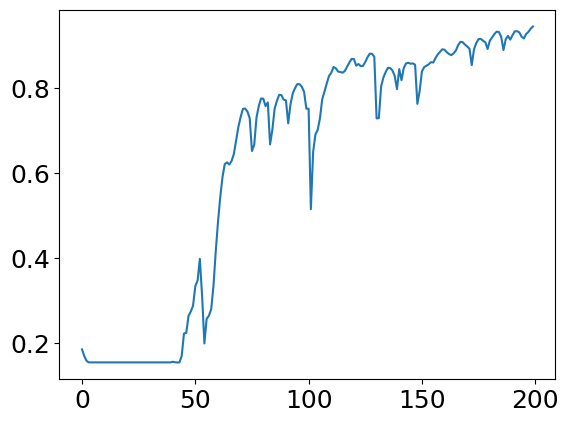

In [30]:
#plt.plot(fitting['loss'])
plt.plot(fitting['accuracy'])

In [12]:
with open(output_path + '/acc.json', 'w') as f:
    json.dump(acc, f)

In [27]:
acc

{-12: 0.3172463768115942,
 -10: 0.40159420289855075,
 -8: 0.5031884057971014,
 -6: 0.6086956521739131,
 -4: 0.6926086956521739,
 -2: 0.7720289855072464,
 0: 0.8360869565217391,
 2: 0.8736231884057971,
 4: 0.9050724637681159,
 6: 0.9184057971014493,
 8: 0.9260869565217391,
 10: 0.9388405797101449,
 12: 0.947536231884058,
 14: 0.9534782608695652,
 16: 0.9494202898550724,
 18: 0.9540579710144927,
 20: 0.9547826086956521}

In [13]:
acc_val = [val*100 for k,val in acc.items()]

In [17]:
len(acc_val)

17

In [21]:
lensnrs

[-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

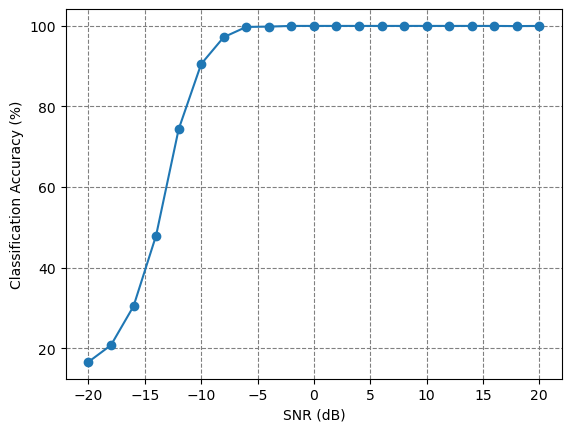

In [16]:
ticks = []
a = np.arange(28, 102, 2)
for i in a:
    if i %10 == 0:
        ticks.append(str(i))
    else:
        ticks.append("")
plt.plot(snrs, acc_val, marker='o')
#plt.xticks(snrs)
plt.grid(color = "grey", linewidth = "0.8", linestyle = "--")
plt.xlabel("SNR (dB)")
plt.ylabel("Classification Accuracy (%)")
plt.savefig(output_path + '/graphs/overall_accuracy.png')

In [ ]:
for k,val in signal_class.items():
    signal_class[k] = list([v*100for v in val])


In [26]:
with open(output_path + '/signal_acc.json', "w") as f:
    json.dump(signal_class, f)

In [21]:
import numpy

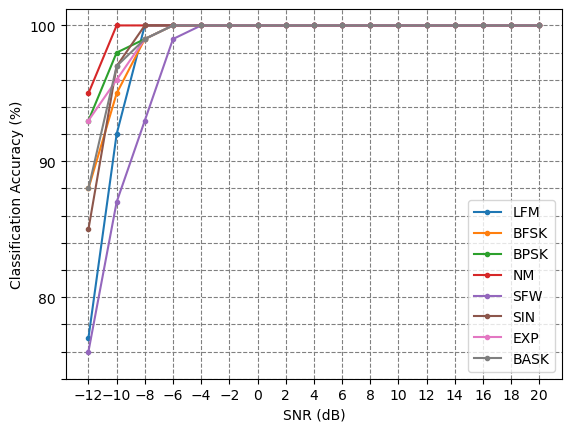

In [15]:
plt.figure()
ticks = []
a = np.arange(74, 102, 2)
for i in a:
    if i % 5 == 0:
        ticks.append(str(i))
    else:
        ticks.append("")
for i in range(len(classes)):
    plt.plot(snrs, signal_class[classes[i]], marker='.')
plt.legend(classes)
plt.yticks(a,ticks)
plt.xticks(snrs)
plt.grid(color = "grey", linewidth = "0.8", linestyle = "--")
plt.xlabel("SNR (dB)")
plt.ylabel("Classification Accuracy (%)")
plt.savefig(output_path+ '/graphs/signal_accuracy.png')